In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import datetime as dt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM

2025-03-04 14:08:01.939713: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-04 14:08:01.946981: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-04 14:08:02.005222: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-04 14:08:02.058701: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1741072082.111620   10232 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1741072082.12

In [17]:
stock = "POWERGRID.NS"
start = dt.datetime(2015, 2, 14)
end = dt.datetime(2025, 2, 14)
df = yf.download(stock, start, end)

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


In [19]:
# Tiền xử lý dữ liệu
df = df.reset_index()
df.to_csv("powergrid.csv", index=False)

data_training = df[['Close']][:int(len(df) * 0.7)]
data_testing = df[['Close']][int(len(df) * 0.7):]

scaler = MinMaxScaler(feature_range=(0, 1))
data_training_scaled = scaler.fit_transform(data_training)

In [21]:
# Tạo dữ liệu huấn luyện
x_train, y_train = [], []
for i in range(100, len(data_training_scaled)):
    x_train.append(data_training_scaled[i - 100:i])
    y_train.append(data_training_scaled[i, 0])

x_train, y_train = np.array(x_train), np.array(y_train)


In [23]:
# Xây dựng mô hình LSTM
model = Sequential([
    LSTM(50, activation='relu', return_sequences=True, input_shape=(x_train.shape[1], 1)),
    Dropout(0.2),
    LSTM(60, activation='relu', return_sequences=True),
    Dropout(0.3),
    LSTM(80, activation='relu', return_sequences=True),
    Dropout(0.4),
    LSTM(120, activation='relu'),
    Dropout(0.5),
    Dense(1)
])

2025-03-04 14:08:37.077849: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
/home/phung/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [25]:
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train, y_train, epochs=50, batch_size=32)


Epoch 1/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 14s 201ms/step - loss: 0.0581
Epoch 2/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 11s 213ms/step - loss: 0.0063
Epoch 3/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 10s 202ms/step - loss: 0.0055
Epoch 4/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 10s 187ms/step - loss: 0.0069
Epoch 5/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 12s 237ms/step - loss: 0.0043
Epoch 6/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 16s 313ms/step - loss: 0.0044
Epoch 7/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 11s 215ms/step - loss: 0.0044
Epoch 8/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 10s 205ms/step - loss: 0.0046
Epoch 9/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 11s 223ms/step - loss: 0.0047
Epoch 10/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 18s 348ms/step - loss: 0.0036
Epoch 11/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 19s 377ms/step - loss: 0.0037
Epoch 12/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 10s 196ms/step - loss: 0.0035
Epoch 13/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 10s 186ms/step - loss: 0.0033
Epoch 14/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 12s 237ms/step - loss: 0.0032
Epoch 15/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 20s 

In [27]:
# Dự đoán tập test
past_100_days = data_training.tail(100)
final_df = pd.concat([past_100_days, data_testing], ignore_index=True)
input_data = scaler.transform(final_df[['Close']])

In [29]:
x_test, y_test = [], []
for i in range(100, len(input_data)):
    x_test.append(input_data[i - 100:i])
    y_test.append(input_data[i, 0])

In [31]:
x_test, y_test = np.array(x_test), np.array(y_test)
y_predicted = model.predict(x_test) * (1 / scaler.scale_[0])
y_test = y_test * (1 / scaler.scale_[0])

24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step


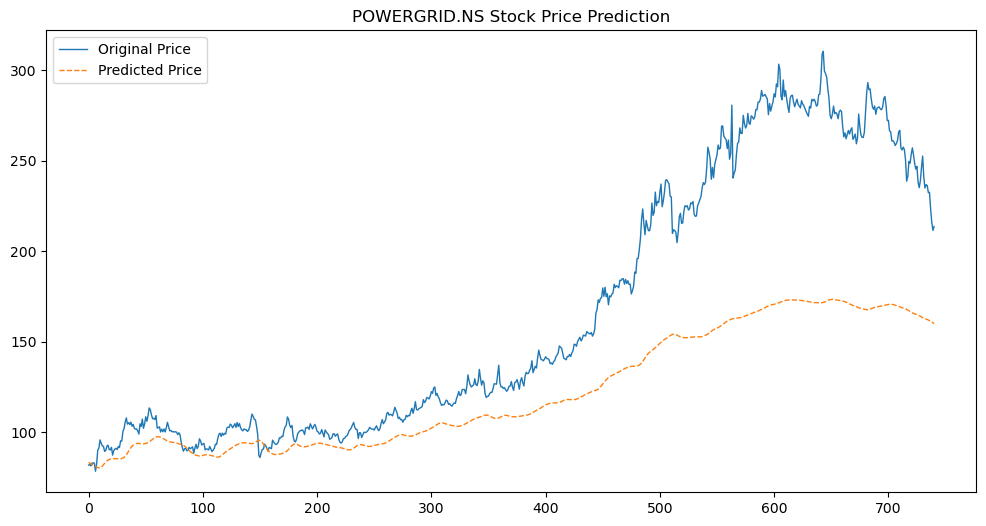

In [33]:
# Vẽ biểu đồ kết quả
plt.figure(figsize=(12, 6))
plt.plot(y_test, label='Original Price', linewidth=1)
plt.plot(y_predicted, label='Predicted Price', linewidth=1, linestyle='dashed')
plt.legend()
plt.title(f'{stock} Stock Price Prediction')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━

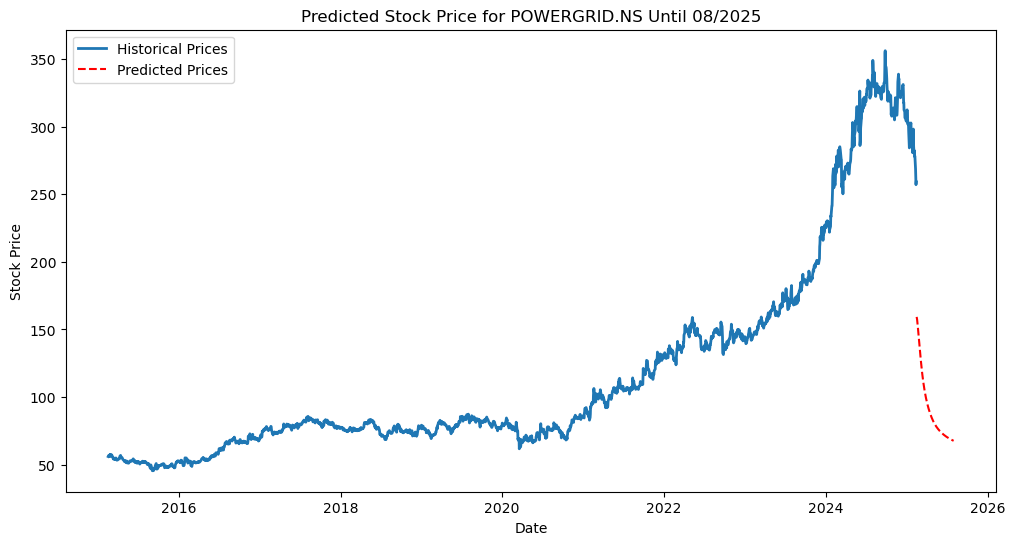

In [35]:
# Dự đoán giá đến tháng 8/2025
future_days = (dt.datetime(2025, 8, 1) - end).days
future_inputs = df.Close[-100:].values.reshape(-1, 1)
future_inputs = scaler.transform(future_inputs).tolist()
future_predictions = []

for _ in range(future_days):
    x_input = np.array(future_inputs[-100:]).reshape(1, 100, 1)
    predicted_price = model.predict(x_input)[0, 0]
    future_predictions.append(predicted_price * (1 / scaler.scale_[0]))
    future_inputs.append([predicted_price])

# Vẽ biểu đồ dự báo
future_dates = [end + dt.timedelta(days=i) for i in range(1, future_days + 1)]
plt.figure(figsize=(12, 6))
plt.plot(df['Date'], df['Close'], label="Historical Prices", linewidth=2)
plt.plot(future_dates, future_predictions, label="Predicted Prices", linestyle='dashed', color='red')
plt.xlabel("Date")
plt.ylabel("Stock Price")
plt.title(f"Predicted Stock Price for {stock} Until 08/2025")
plt.legend()
plt.show()